## Transfer learning from public Figshare dataset

It seems that there is another public training set for this problem available on Figshare. 
The test set is being revised to remove this previously released data, but we can still try to learn
something from this public data that we could transfer to learning from our training data. 

Note that the kaggle training set is ~96k observations vs. ~160k from Figshare, so this is a significant 
increase in our training data size. Unfortunately the labels are different, so we cannoth simply combine these
two datasets and learn one model over them. Instead I want to try learning a model on the Figshare data and
then transfer the trained initial layers to a new model that is then trained on the kaggle labels (i.e. transfer learning)

Figshare data metadata: https://meta.wikimedia.org/wiki/Research:Detox/Data_Release#Toxicity


**Schema for toxicity_annotations.tsv**

* *rev_id*: MediaWiki revision id of the edit that added the comment to a talk page (i.e. discussion).
* *worker_id*: Anonymized crowd-worker id.
* *toxicity_score*: Categorical variable ranging from very toxic (-2), to neutral (0), to very healthy (2).
* *toxicity*: Indicator variable for whether the worker thought the comment is toxic. The annotation takes on the value 1 if the worker considered the comment toxic (i.e worker gave a toxicity_score less than 0) and value 0 if the worker considered the comment neutral or healthy (i.e worker gave a toxicity_score greater or equal to 0). Takes on values in {0, 1}.


In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, Conv1D, Embedding, Dropout, Activation, Flatten
from keras.layers import GlobalMaxPool1D, MaxPooling1D, concatenate
from keras.layers import Bidirectional,LSTM
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils.np_utils import to_categorical
from keras.regularizers import l2

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle 

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
pd.set_option('max_colwidth',140)

### Read in figshare data

In the Figshare data the comments and labels are in separate files. They also appear to include the scores from each human judge, so there are multple rows per comment in the annotations file.

In [6]:
figshare_annotations = pd.read_csv("../figshare data/toxicity_annotations.tsv",sep='\t')
print(figshare_annotations.shape)
figshare_annotations.head()

(1598289, 4)


,rev_id,worker_id,toxicity,toxicity_score
0,2232.0,723,0,0.0
1,2232.0,4000,0,0.0
2,2232.0,3989,0,1.0
3,2232.0,3341,0,0.0
4,2232.0,1574,0,1.0


In [7]:
figshare_comments = pd.read_csv("../figshare data/toxicity_annotated_comments.tsv",sep='\t')
print(figshare_comments.shape)

figshare_comments['comment'] = figshare_comments['comment'].str.replace('NEWLINE_TOKEN',' ')
figshare_comments['comment'] = figshare_comments['comment'].str.replace('TAB_TOKEN',' ')
figshare_comments.head()

(159686, 7)


,rev_id,comment,year,logged_in,ns,sample,split
0,2232.0,This: :One can make an analogy in mathematical terms by envisioning the distribution of opinions in a population as a Gaussian curve. We...,2002,True,article,random,train
1,4216.0,"` :Clarification for you (and Zundark's right, i should have checked the Wikipedia bugs page first). This is a ``bug`` in the code t...",2002,True,user,random,train
2,8953.0,Elected or Electoral? JHK,2002,False,article,random,test
3,26547.0,`This is such a fun entry. Devotchka I once had a coworker from Korea and not only couldn't she tell the difference between USA-Engli...,2002,True,article,random,train
4,28959.0,"Please relate the ozone hole to increases in cancer, and provide figures. Otherwise, this article will be biased toward the environmenta...",2002,True,article,random,test


### Basic data exploration

In [8]:
figshare_comments.groupby('split')['rev_id'].count()

split
dev      32128
test     31866
train    95692
Name: rev_id, dtype: int64

In [9]:
figshare_comments[figshare_comments['rev_id'].isin(
    figshare_annotations[figshare_annotations['toxicity_score']==-2]['rev_id'].sample(10))]

,rev_id,comment,year,logged_in,ns,sample,split
21735,67151175.0,"== You bastard == You bastard, you deleated my article before I even had time to write it. You suck.",2006,True,user,blocked,train
33779,104794459.0,"== This guy is a fucking loser== Hey nerd, get a fucking life and stop editing shit out and warning me, who gave you the right? Just ...",2007,False,user,blocked,dev
47471,154524710.0,FUCK U! U FUCKEN STOLE MY CLOUDSONG AND IF I EVER FUCKEN FIND U FUUUUUUUUUUCK FUCK U!,2007,True,user,blocked,test
54309,179908303.0,== Shit == keep your sorry ass shit post off my page,2007,True,user,blocked,train
60765,199917660.0,== Stefano == It would be a much better world if you kept your nose to the grindstone and give up on Stefano. You have behaved well f...,2008,False,user,blocked,train
75635,254617673.0,Look you little cocksucker. I did nothing wrong. I am sick of your bullshit harassment and you are really starting to piss me off you ...,2008,True,user,blocked,test
93705,330815595.0,== RE: Wikipedia Firearms Project == I think New Yorkers should be allowed to have guns so they can shoot people like you.,2009,False,user,blocked,train
111402,416341391.0,"Please refrain from unmaking unconstructive edits to Wikipedia, as you did at Tim Pawlenty. Your edits appear to constitute whitewashi...",2011,False,user,blocked,train
118228,452926013.0,"== LOL Nawlin, you are so predictable it's funny. == I knew you would spot my edits within a few hours and quickly censor them becaus...",2011,False,user,blocked,test
119027,456896279.0,F u c k i n g c u n t s get a life you sad f u c k i n g gits.,2011,True,user,blocked,train


In [10]:
figshare_mean_toxic_rating = figshare_annotations.groupby('rev_id')[['toxicity','toxicity_score']].mean().reset_index()
figshare_mean_toxic_rating['toxicity_score'] = -1*figshare_mean_toxic_rating['toxicity_score']
print(figshare_mean_toxic_rating.shape)
figshare_mean_toxic_rating.head()

(159686, 3)


,rev_id,toxicity,toxicity_score
0,2232.0,0.1,-0.4
1,4216.0,0.0,-0.5
2,8953.0,0.0,-0.1
3,26547.0,0.0,-0.6
4,28959.0,0.2,-0.2


In [11]:
np.mean(figshare_mean_toxic_rating['toxicity'])

0.14504894359788023

Important: the Figshare data has a higher rate of toxic comments

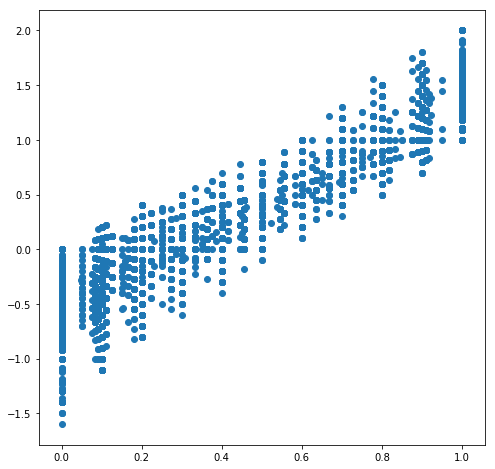

In [12]:
plt.figure(figsize=(8, 8))
plt.scatter(figshare_mean_toxic_rating['toxicity'],figshare_mean_toxic_rating['toxicity_score'])

In [28]:
print(np.std(figshare_mean_toxic_rating['toxicity']),np.std(figshare_mean_toxic_rating['toxicity_score']))

0.25386501321939464 0.5032696436893133


In [34]:
print(np.mean(figshare_mean_toxic_rating['toxicity_score']>1))
print(np.mean(figshare_mean_toxic_rating['toxicity']>0.5))

0.042815274977142645
0.09620129504151897


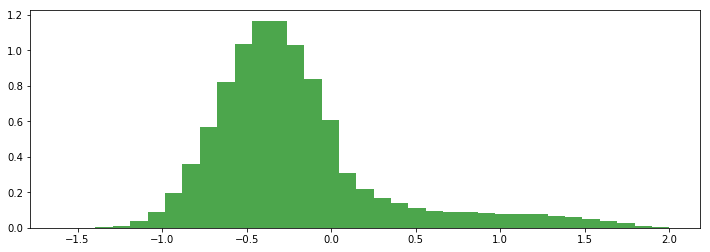

In [26]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(figshare_mean_toxic_rating['toxicity_score'], 35, normed=1, facecolor='green', alpha=0.7)

In [49]:
figshare_comments[figshare_comments['rev_id'].isin(
figshare_mean_toxic_rating[
    (figshare_mean_toxic_rating['toxicity_score']>.55) & (figshare_mean_toxic_rating['toxicity_score']<.60)
]['rev_id'].sample(10)
)]

,rev_id,comment,year,logged_in,ns,sample,split
30988,94598810.0,== Lonelyboy == Stop writing messages to Lonelyboy on my page. That's probably how a lot of crap was started here before because of y...,2006,False,user,blocked,train
40551,128824839.0,`::Nice wording there. That's the point. It's a fact. It's not a ``portrayal`` that is ``too positive``. It's a fucking FACT. What ...,2007,True,article,blocked,test
42686,136907063.0,YOUR MOM's Va jay jay,2007,False,user,blocked,test
66288,218626733.0,OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES OH NOES ...,2008,False,user,blocked,test
69682,230593131.0,MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MUD MU...,2008,False,user,blocked,test
72209,240235526.0,` How dare you call ME the vandal or a Yankees fan. I am neither. Paul Byrd does have a pig nose and closely resembles a swine so that ...,2008,True,user,random,dev
96029,341425437.0,== sockpuppet == whose sockpuppet are you?,2010,True,user,blocked,dev
97002,345963714.0,lol wtf i aint vandalising seriously i tried not to hurt yo feelins tht time,2010,True,user,blocked,train
100210,361618613.0,` I AM SHADOWJAMS WORST NIGHTMERE..... ``THE WIKIPEDIA HACKER`` `,2010,False,user,blocked,dev
109121,404329048.0,` ===Czechoslovak fan panslavist idiote== ``Please do not create attack pages as you did at User talk:Iaaasi. Attack pages and files a...,2010,False,user,blocked,dev


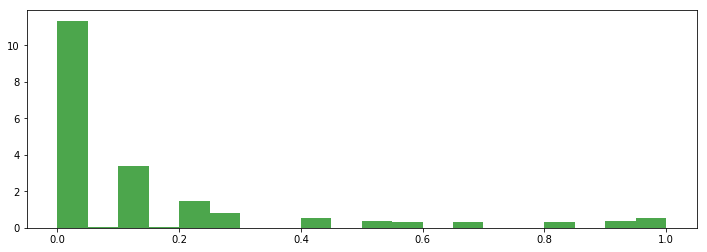

In [14]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(figshare_mean_toxic_rating['toxicity'], 20, normed=1, facecolor='green', alpha=0.7)

In [35]:
# annotators per comment
comment_annotation_count = figshare_annotations.groupby('rev_id')['worker_id'].count().reset_index()
comment_annotation_count['worker_id'].describe()

count    159686.000000
mean         10.008949
std           0.450793
min           8.000000
25%          10.000000
50%          10.000000
75%          10.000000
max          21.000000
Name: worker_id, dtype: float64

In [40]:
worker_bias = figshare_annotations.groupby('worker_id')['toxicity_score'].mean().reset_index()
worker_bias.head()

,worker_id,toxicity_score
0,0,-0.208768
1,1,0.000000
2,2,0.258403
3,3,0.689373
4,4,-0.105263


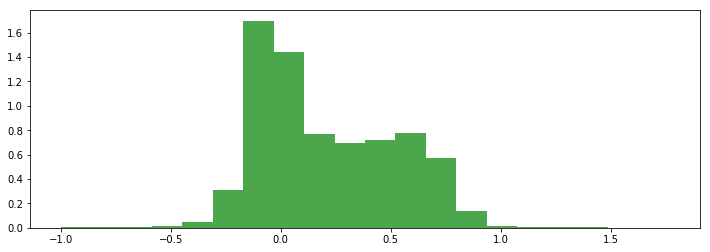

In [41]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(worker_bias['toxicity_score'], 20, normed=1, facecolor='green', alpha=0.7)

### Comment processing

In [13]:
comments = figshare_comments['comment'].tolist()

In [14]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("NEWLINE_TOKEN",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("TAB_TOKEN",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
            token_dict[token] += 1
        else:
            token_set.add(token)
            token_dict[token] = 1

In [15]:
# token count from kaggle data
token_count = pd.read_csv("../token_count.csv",na_values=None,keep_default_na=False)
token_count = token_count[['token','freq']]
token_count.head()

,token,freq
0,the,1118947
1,to,667698
2,of,470204
3,and,450762
4,a,445528


In [16]:
reduced_token_count = token_count[token_count['freq']>=10].reset_index()
print(reduced_token_count.shape)
reduced_token_set = set(reduced_token_count['token'])

(41286, 3)


In [17]:
index_token_dict = pd.Series(reduced_token_count.token.values,index=reduced_token_count.index.values+1).to_dict()
token_index_dict = pd.Series(reduced_token_count.index.values+1,index=reduced_token_count.token.values).to_dict()

In [18]:
tokenized_corpus = []
for line in tokenized_comments:
    line_token_idx = []
    for t in line:
        if t in reduced_token_set:
            line_token_idx += [token_index_dict[t]]
    tokenized_corpus += [line_token_idx]

In [19]:
tokenized_corpus[100]

[121, 79, 39740, 5, 710, 545, 2613, 363]

In [20]:
comment_length = []
for comment in tokenized_comments:
    comment_length.append(len(comment))
comment_length = np.array(comment_length)
np.mean(comment_length>200)

0.06370001127212153

(0, 400)

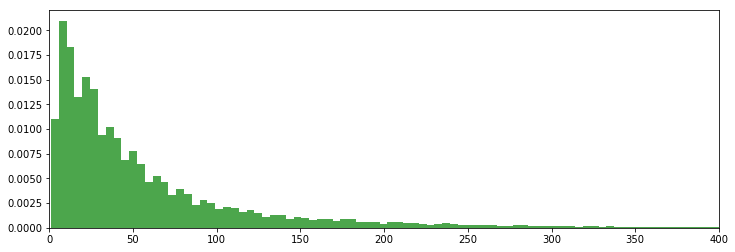

In [21]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(comment_length, 300, normed=1, facecolor='green', alpha=0.7)
plt.xlim([0,400])

In [22]:
MAX_SEQ_LENGTH=200
tokenized_corpus_padded = pad_sequences(tokenized_corpus,maxlen=MAX_SEQ_LENGTH)

### Load FastText embeddings

In [23]:
fasttext_model = gensim.models.Word2Vec.load("../wiki_fasttext_embed")

In [24]:
print(len(fasttext_model.wv.vocab))
print(reduced_token_count.shape)

88829
(41286, 3)


In [25]:
V = len(reduced_token_set)+1
EMBEDDING_DIM=300
print((V,EMBEDDING_DIM))

(41287, 300)


In [26]:
embed_matrix = np.zeros((V,EMBEDDING_DIM))
for token in token_index_dict.keys():
    embed_matrix[token_index_dict[token]] = fasttext_model.wv[token]

### Split training data into train,valid sets

In [27]:
rating_label = figshare_mean_toxic_rating['toxicity_score']
rating_label0,tokenized_corpus_padded0 = shuffle(rating_label,tokenized_corpus_padded)

In [28]:
rating_label_train,rating_label_valid, seq_train,seq_valid  = \
    train_test_split(rating_label0,tokenized_corpus_padded0,test_size=0.2)

In [29]:
print(rating_label_train.shape)
print(rating_label_valid.shape)

(127748,)
(31938,)


## Convolutional model

In [30]:
# Sequence input
sequence_input = Input(shape=(MAX_SEQ_LENGTH,),dtype='int32',name='Input')

# Embedding lookup
embed_seq_unmasked = Embedding(input_dim=V
                              ,output_dim=EMBEDDING_DIM
                              ,weights=[embed_matrix]
                              ,input_length=MAX_SEQ_LENGTH
                              ,trainable=False
                              ,mask_zero=False
                              ,name='Embedding')(sequence_input)

In [38]:
# Convolutional layers: width 7
Conv7_layer = Conv1D(64,7,activation='relu',padding='same')(embed_seq_unmasked)
Conv7_layer = MaxPooling1D(2)(Conv7_layer)
Conv7_layer = Conv1D(64,7,activation='relu',padding='same')(Conv7_layer)
Conv7_layer = GlobalMaxPool1D()(Conv7_layer)
Conv7_layer = Dropout(0.5)(Conv7_layer)

In [39]:
Conv_dense = Dense(32,activation='relu',kernel_regularizer=regularizers.l2(0.0001))(Conv7_layer)
Conv_output = Dense(1, activation="linear")(Conv_dense)

In [40]:
cnn_model = Model(inputs=sequence_input, outputs=Conv_output)
cnn_model.compile(loss='mean_squared_error', optimizer='adagrad')
cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           (None, 200)               0         
_________________________________________________________________
Embedding (Embedding)        (None, 200, 300)          12386100  
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 64)           134464    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 100, 64)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 100, 64)           28736     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
__________

In [41]:
history_CNN = cnn_model.fit(seq_train,rating_label_train
                           ,epochs=5
                           ,batch_size=16
                           ,validation_data=(seq_valid,rating_label_valid)
                           ,verbose=1)

Train on 127748 samples, validate on 31938 samples
Epoch 1/5
127748/127748 [==============================] - 708s - loss: 0.0879 - val_loss: 0.0840
Epoch 2/5
127748/127748 [==============================] - 708s - loss: 0.0740 - val_loss: 0.0787
Epoch 3/5
127748/127748 [==============================] - 707s - loss: 0.0702 - val_loss: 0.0759
Epoch 4/5
127748/127748 [==============================] - 706s - loss: 0.0672 - val_loss: 0.0731
Epoch 5/5
127748/127748 [==============================] - 706s - loss: 0.0645 - val_loss: 0.0774


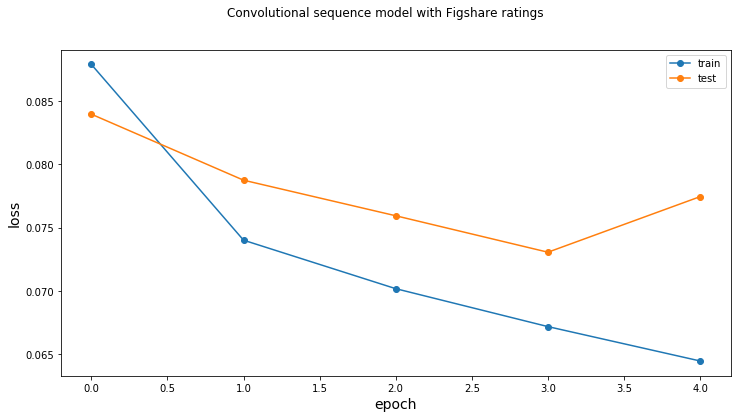

In [42]:
plt.figure(figsize=(12,6))
plt.suptitle("Convolutional sequence model with Figshare ratings")
#plt.subplot(121)
plt.plot(history_CNN.history['loss'],'-o',label='train')
plt.plot(history_CNN.history['val_loss'],'-o',label='test')
plt.legend()
plt.xlabel('epoch',fontsize=14)
plt.ylabel('loss',fontsize=14)

In [48]:
cnn_model.save("figshare_rating_cnn")

In [43]:
cnn_predict = cnn_model.predict(seq_valid)

In [49]:
cnn_predict = cnn_predict[:,0]

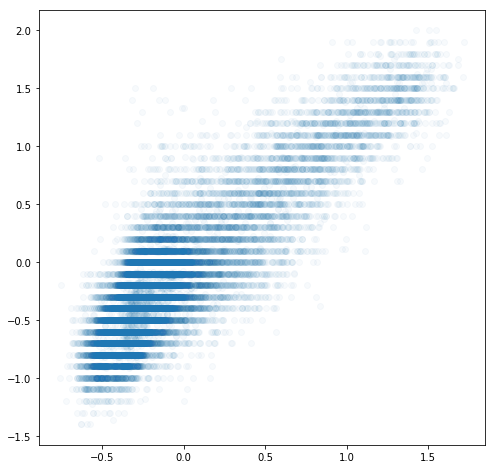

In [62]:
plt.figure(figsize=(8,8))
plt.scatter(cnn_predict,rating_label_valid,alpha=.03)

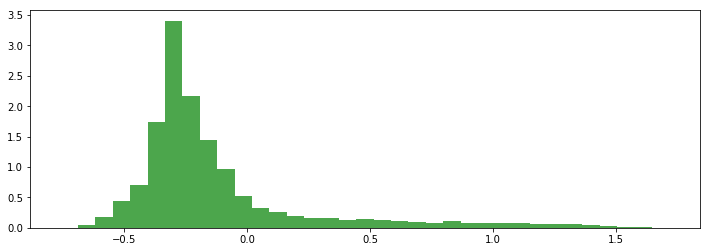

In [58]:
plt.figure(figsize=(12, 4))
n, bins, patches = plt.hist(cnn_predict, 35, normed=1, facecolor='green', alpha=0.7)

In [54]:
cnn_mse=np.mean((cnn_predict-rating_label_valid)**2)
rating_var = np.var(rating_label_valid)
1 - (cnn_mse/rating_var)

0.7018732285775813

In [63]:
np.mean((cnn_predict-rating_label_valid))

0.08186777180413285